In [1]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL.Image import Image
import PIL.Image as pil
import pickle

Extracting features of query image:

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
upImgs1 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_1")
dataBatch1 = upImgs1[b'data']

upImgs2 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_2")
dataBatch2 = upImgs2[b'data']

upImgs3 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_3")
dataBatch3 = upImgs3[b'data']

upImgs4 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_1")
dataBatch4 = upImgs4[b'data']

upImgs5 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_1")
dataBatch5 = upImgs5[b'data']

meta_data = unpickle("E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\batches.meta")

In [4]:
datasetImgs = np.append(dataBatch1, dataBatch2, axis=0)
datasetImgs = np.append(datasetImgs, dataBatch3, axis=0)
datasetImgs = np.append(datasetImgs, dataBatch4, axis=0)
datasetImgs = np.append(datasetImgs, dataBatch5, axis=0)
print(datasetImgs, datasetImgs.shape)
print(type(datasetImgs))

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]] (50000, 3072)
<class 'numpy.ndarray'>


In [5]:
print(datasetImgs[0, ], datasetImgs[0, ].shape) # first image in batch1 of dataset

[ 59  43  50 ... 140  84  72] (3072,)


In [6]:
print(dataBatch1, dataBatch1.shape)
print(dataBatch1[0, ], dataBatch1[0, ].shape)

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]] (10000, 3072)
[ 59  43  50 ... 140  84  72] (3072,)


Feature Extractor :

In [7]:
class FeatureExtractor: # for reference
    def __init__(self):
        base_model = VGG19(weights='imagenet') # find for VGG19
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

    def extract(self, img):
        img = img.resize((224, 224)) 
        img = img.convert('RGB')  
        x = image.img_to_array(img) 
        x = np.expand_dims(x, axis=0)  
        x = preprocess_input(x)  
        feature = self.model.predict(x)[0] 
        return feature / np.linalg.norm(feature)

In [8]:
class FeatureExtractorSISE: # actual class used
    def __init__(self):
        base_model = VGG19(include_top=False, weights='imagenet', input_shape=(48,48,3))
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv4').output)
        
    def extractSISEQ(self, img):          # for query image 
        img = img.resize((48,48))
        img = img.convert('RGB')
        z1 = image.img_to_array(img)
        z2 = np.expand_dims(z1, axis=0)
        z3 = preprocess_input(z2)                
        feature = self.model.predict(z3)[0]       # (1, 4096) -> (4096,)
        return feature/np.linalg.norm(feature)   # Normalizing
    
    def extractSISED(self, dataset_img):   # for dataset images  
        dataset_img = np.resize(dataset_img, (3,48,48))
        dataset_img = dataset_img.transpose(1, 2, 0)
        exp_dims_datasetimgs = np.expand_dims(dataset_img, axis=0)
        pp_input_datasetimgs = preprocess_input(exp_dims_datasetimgs)                
        feature_datasetimgs = self.model.predict(pp_input_datasetimgs)[0]       # (1, 4096) -> (4096,)
        return feature_datasetimgs/np.linalg.norm(feature_datasetimgs)   # Normalizing

In [9]:
class FeatureExtractorM:  # Matsui's code
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        """
        Extract a deep feature from an input image
        Args:
            img: from PIL.Image.open(path) or tensorflow.keras.preprocessing.image.load_img(path)
        Returns:
            feature (np.ndarray): deep feature with the shape=(4096, )
        """
        img = img.resize((224, 224))  # VGG must take a 224x224 img as an input
        img = img.convert('RGB')  # Make sure img is color
        x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
        x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
        x = preprocess_input(x)  # Subtracting avg values for each pixel
        feature = self.model.predict(x)[0]  # (1, 4096) -> (4096, )
        return feature / np.linalg.norm(feature)  # Normalize

In [10]:
image_path_query = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg'
queryFeatures = FeatureExtractorSISE().extractSISEQ(img=pil.open(image_path_query))    # Features of Query Image
print(queryFeatures)
print(queryFeatures.shape)
print(type(queryFeatures))

[[[0.         0.         0.         ... 0.         0.         0.02263478]
  [0.         0.         0.         ... 0.         0.         0.01624876]
  [0.         0.         0.         ... 0.         0.         0.02574723]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.01062487]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
(3, 3, 512)
<class 'numpy.ndarray'>


In [11]:
features = [] # for only databatch1, 10000 images from entire dataset
no = 0
for i in dataBatch1:
    datasetFeatures = FeatureExtractorSISE().extractSISED(dataBatch1[i, ])
    no = no+1
    print(no)
    features.append(datasetFeatures)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764


3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403


4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042


6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586
6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681


8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320


9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959


In [12]:
features = np.array(features)
print(features, features.shape)

[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.00617675
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]


 [[[0.         0.         0.         ... 0.         0.00783338
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.00512905
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.

In [15]:
features[87]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

Searching image dataset for query image & closest dist :

In [25]:
dists = np.linalg.norm(features-queryFeatures, axis=1) 
print(dists, dists.shape)

[[[0.         0.         0.         ... 0.         0.         0.02500442]
  [0.         0.         0.         ... 0.         0.         0.01624876]
  [0.         0.         0.         ... 0.         0.00617675 0.02574723]]

 [[0.         0.         0.         ... 0.         0.00783338 0.02500442]
  [0.         0.         0.         ... 0.         0.         0.01624876]
  [0.         0.         0.         ... 0.         0.00512905 0.02574723]]

 [[0.         0.         0.         ... 0.         0.01789575 0.02500442]
  [0.         0.         0.         ... 0.         0.00106738 0.01624876]
  [0.         0.         0.         ... 0.         0.03769569 0.02574723]]

 ...

 [[0.         0.         0.         ... 0.         0.00636981 0.02500442]
  [0.         0.         0.         ... 0.         0.         0.01624876]
  [0.         0.         0.         ... 0.         0.03701076 0.02574723]]

 [[0.         0.         0.         ... 0.         0.         0.02500442]
  [0.         0.        

In [60]:
# dists = np.linalg.norm(features-queryFeatures, axis=1) 
ids = np.argsort(dists)[:3]  # Top 8 results
# scores = [dists[id] for id in ids]
# print(scores)
print(ids)

[[[  0 260 436 ... 259  53  30]
  [  0 278 277 ... 379  30  53]
  [  0 256 433 ... 259  53  30]]

 [[  0 266 265 ... 259  30  53]
  [  0 280 279 ... 506  30  53]
  [  0 264 263 ... 259  30  53]]

 [[  0 266 265 ... 455  30  53]
  [  0 283 453 ... 177  30  53]
  [  0 257 256 ... 259  53  30]]]


# ============= Rough Stuff =================

In [10]:
img_path = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg'
imgT = image.load_img(img_path, target_size=(224, 224))
i2a = image.img_to_array(imgT)
expD = np.expand_dims(i2a, axis=0)
pp = preprocess_input(expD)

In [13]:
print(i2a, i2a.shape)

[[[ 90.32       100.221      128.061     ]
  [ 86.32        96.221      124.061     ]
  [ 80.32        90.221      120.061     ]
  ...
  [ 81.32        93.221      125.061     ]
  [ 81.32        93.221      125.061     ]
  [ 79.32        91.221      123.061     ]]

 [[ 81.32        91.221      119.061     ]
  [ 83.32        93.221      121.061     ]
  [ 81.32        91.221      119.061     ]
  ...
  [ 79.32        91.221      123.061     ]
  [ 79.32        91.221      123.061     ]
  [ 78.32        90.221      122.061     ]]

 [[ 79.32        89.221      117.061     ]
  [ 80.32        90.221      118.061     ]
  [ 81.32        90.221      118.061     ]
  ...
  [ 78.32        90.221      122.061     ]
  [ 78.32        90.221      122.061     ]
  [ 77.32        89.221      121.061     ]]

 ...

 [[ 33.32         9.221001    -6.939003  ]
  [102.32        86.221       67.061     ]
  [  6.3199997  -18.779      -28.939003  ]
  ...
  [  3.3199997  -18.779      -39.939003  ]
  [ 46.32        2

In [12]:
res = np.resize(i2a, (224,224))
print(res, res.shape)

[[ 90.32      100.221     128.061     ... 116.061      19.32
   71.221    ]
 [123.061      14.32       70.221     ...  83.221     116.061
   61.32     ]
 [ 79.221     112.061      60.32      ...  79.32       91.221
  123.061    ]
 ...
 [-27.779     -27.939003  -32.68      ...  90.32      101.221
  126.061    ]
 [ 50.32       67.221     105.061     ... -30.939003   -1.6800003
  -12.778999 ]
 [-11.939003  -40.68      -51.779     ...  25.221      21.060997
    7.3199997]] (224, 224)


In [7]:
expD

array([[[[214., 217., 232.],
         [210., 213., 228.],
         [204., 207., 224.],
         ...,
         [205., 210., 229.],
         [205., 210., 229.],
         [203., 208., 227.]],

        [[205., 208., 223.],
         [207., 210., 225.],
         [205., 208., 223.],
         ...,
         [203., 208., 227.],
         [203., 208., 227.],
         [202., 207., 226.]],

        [[203., 206., 221.],
         [204., 207., 222.],
         [205., 207., 222.],
         ...,
         [202., 207., 226.],
         [202., 207., 226.],
         [201., 206., 225.]],

        ...,

        [[157., 126.,  97.],
         [226., 203., 171.],
         [130.,  98.,  75.],
         ...,
         [127.,  98.,  64.],
         [170., 138., 100.],
         [132.,  98.,  70.]],

        [[155., 117.,  81.],
         [128.,  84.,  55.],
         [144., 117.,  88.],
         ...,
         [155., 125.,  89.],
         [153., 115.,  78.],
         [147., 111.,  77.]],

        [[140., 104.,  72.],
       

In [9]:
pp

array([[[[128.061     , 100.221     ,  90.32      ],
         [124.061     ,  96.221     ,  86.32      ],
         [120.061     ,  90.221     ,  80.32      ],
         ...,
         [125.061     ,  93.221     ,  81.32      ],
         [125.061     ,  93.221     ,  81.32      ],
         [123.061     ,  91.221     ,  79.32      ]],

        [[119.061     ,  91.221     ,  81.32      ],
         [121.061     ,  93.221     ,  83.32      ],
         [119.061     ,  91.221     ,  81.32      ],
         ...,
         [123.061     ,  91.221     ,  79.32      ],
         [123.061     ,  91.221     ,  79.32      ],
         [122.061     ,  90.221     ,  78.32      ]],

        [[117.061     ,  89.221     ,  79.32      ],
         [118.061     ,  90.221     ,  80.32      ],
         [118.061     ,  90.221     ,  81.32      ],
         ...,
         [122.061     ,  90.221     ,  78.32      ],
         [122.061     ,  90.221     ,  78.32      ],
         [121.061     ,  89.221     ,  77.32      ]],

In [2]:
m = VGG19()
print(m.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [31]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

unp_imgs1 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_1")
unp_imgs2 = unpickle("E:\\VIDND\Projects\\Small Image Search Engine (SISE)\\cifar-10\\cifar-10-batches-py\\data_batch_2")

In [32]:
unp_imgs1

{b'batch_label': b'training batch 1 of 5',
 b'labels': [6,
  9,
  9,
  4,
  1,
  1,
  2,
  7,
  8,
  3,
  4,
  7,
  7,
  2,
  9,
  9,
  9,
  3,
  2,
  6,
  4,
  3,
  6,
  6,
  2,
  6,
  3,
  5,
  4,
  0,
  0,
  9,
  1,
  3,
  4,
  0,
  3,
  7,
  3,
  3,
  5,
  2,
  2,
  7,
  1,
  1,
  1,
  2,
  2,
  0,
  9,
  5,
  7,
  9,
  2,
  2,
  5,
  2,
  4,
  3,
  1,
  1,
  8,
  2,
  1,
  1,
  4,
  9,
  7,
  8,
  5,
  9,
  6,
  7,
  3,
  1,
  9,
  0,
  3,
  1,
  3,
  5,
  4,
  5,
  7,
  7,
  4,
  7,
  9,
  4,
  2,
  3,
  8,
  0,
  1,
  6,
  1,
  1,
  4,
  1,
  8,
  3,
  9,
  6,
  6,
  1,
  8,
  5,
  2,
  9,
  9,
  8,
  1,
  7,
  7,
  0,
  0,
  6,
  9,
  1,
  2,
  2,
  9,
  2,
  6,
  6,
  1,
  9,
  5,
  0,
  4,
  7,
  6,
  7,
  1,
  8,
  1,
  1,
  2,
  8,
  1,
  3,
  3,
  6,
  2,
  4,
  9,
  9,
  5,
  4,
  3,
  6,
  7,
  4,
  6,
  8,
  5,
  5,
  4,
  3,
  1,
  8,
  4,
  7,
  6,
  0,
  9,
  5,
  1,
  3,
  8,
  2,
  7,
  5,
  3,
  4,
  1,
  5,
  7,
  0,
  4,
  7,
  5,
  5,
  1,
  0,
  9,
  6,
  9,
 

In [33]:
print(unp_imgs1[b'data'])

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]


In [34]:
print(unp_imgs2[b'data'])

[[ 35  27  25 ... 169 168 168]
 [ 20  20  18 ... 111  97  51]
 [116 115 155 ...  18  84 124]
 ...
 [127 139 155 ... 197 192 191]
 [190 200 208 ... 163 182 192]
 [177 174 182 ... 119 127 136]]


In [30]:
print(type(unp_imgs[b'data']), unp_imgs[b'data'].shape)

<class 'numpy.ndarray'> (10000, 3072)


In [38]:
np.append(unp_imgs1[b'data'], unp_imgs2[b'data'], axis=0)

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [127, 139, 155, ..., 197, 192, 191],
       [190, 200, 208, ..., 163, 182, 192],
       [177, 174, 182, ..., 119, 127, 136]], dtype=uint8)

In [3]:
M = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

NameError: name 'base_model' is not defined

In [2]:
image_path_query = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg'
img_op = Image.open(image_path_query)
img = img_op.resize((224, 224)) 
img = img.convert('RGB')  
x1 = image.img_to_array(img) 
x2 = np.expand_dims(x1, axis=0)  
x3 = preprocess_input(x2)  
feature = M.predict(x3)[0] 
ret = feature / np.linalg.norm(feature)

NameError: name 'M' is not defined

In [43]:
image_path_query = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg'
with pil.open(image_path_query) as im:
    rez = im.resize((224, 224))
print(rez)

<PIL.Image.Image image mode=RGB size=224x224 at 0x206EA777100>


In [57]:
class FeatureExtractorSISET:   
    def __init__(self):
        base_model = VGG19(include_top=False, weights='imagenet', input_shape=(48,48,3))
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv4').output)
        
    def extractSISEQ(self, img):          # for query image 
        img = img.resize((224,224))
        img = img.convert('RGB')
        z1 = image.img_to_array(img)
        z2 = np.expand_dims(z1, axis=0)
        z3 = preprocess_input(z2)                
        feature = self.model.predict(z3)[0]       # (1, 4096) -> (4096,)
        return feature/np.linalg.norm(feature)   # Normalizing
    
    def extractSISED(self, dataset_img):   # for dataset images  
        dataset_img = np.resize(dataset_img, (3,48,48))
        dataset_img = dataset_img.transpose(1, 2, 0)
        exp_dims_datasetimgs = np.expand_dims(dataset_img, axis=0)
        pp_input_datasetimgs = preprocess_input(exp_dims_datasetimgs)                
        feature_datasetimgs = self.model.predict(pp_input_datasetimgs)[0]       # (1, 4096) -> (4096,)
        return feature_datasetimgs/np.linalg.norm(feature_datasetimgs)   # Normalizing

In [56]:
print(d, d.shape)
im = np.resize(d, (3, 48, 48))
print(im, im.shape)
im = im.transpose(1, 2, 0)
print(im, im.shape)
exp = np.expand_dims(im, axis=0)
print(exp, exp.shape)
prepro = preprocess_input(im)
print(prepro, prepro.shape)

[154 126 105 ... 139 142 144] (3072,)
[[[154 126 105 ... 218 240 245]
  [241 238 234 ...  79  68  67]
  [136 137 122 ...  32 130 241]
  ...
  [226 207 196 ...  60  57  74]
  [149 165 164 ... 105 125 148]
  [181 219 234 ...  82  71  62]]

 [[138 102  67 ... 146  61  56]
  [ 92 203 235 ...  84  77  63]
  [ 67 144 143 ... 152 103  91]
  ...
  [ 97 199 230 ... 102  79  84]
  [ 89 118  92 ... 224 183 150]
  [168 215 231 ... 172 178 144]]

 [[188 237 228 ... 232 224 221]
  [219 219 219 ... 132 179 167]
  [136 141 124 ... 141 146 116]
  ...
  [101 134 162 ... 210 208 204]
  [155 162 152 ... 126 139 154]
  [165 137 159 ...  69  97 176]]] (3, 48, 48)
[[[154 138 188]
  [126 102 237]
  [105  67 228]
  ...
  [218 146 232]
  [240  61 224]
  [245  56 221]]

 [[241  92 219]
  [238 203 219]
  [234 235 219]
  ...
  [ 79  84 132]
  [ 68  77 179]
  [ 67  63 167]]

 [[136  67 136]
  [137 144 141]
  [122 143 124]
  ...
  [ 32 152 141]
  [130 103 146]
  [241  91 116]]

 ...

 [[226  97 101]
  [207 199 134]


In [58]:
d = datasetImgs[1, ]
dFs = FeatureExtractorSISET().extractSISED(d)
print(dFs)
print(dFs.shape)

[[[0.         0.         0.         ... 0.         0.01395447 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.05115408 0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.02525747 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
(3, 3, 512)


In [44]:
image_path_query = 'E:\\VIDND\\Projects\\Small Image Search Engine (SISE)\\elephant.jpg'
im1 = pil.open(image_path_query)
im1 = im1.resize((48, 48))
print(im1)
im1 = im1.convert('RGB')
print(im1)
z = image.img_to_array(im1)
print(z, z.shape)
z = np.expand_dims(z, axis=0)
print(z, z.shape)

<PIL.Image.Image image mode=RGB size=48x48 at 0x15CD1F07BB0>
<PIL.Image.Image image mode=RGB size=48x48 at 0x15CD3E42A30>
[[[201. 205. 222.]
  [202. 208. 226.]
  [198. 203. 221.]
  ...
  [214. 221. 235.]
  [208. 214. 231.]
  [202. 207. 227.]]

 [[211. 215. 229.]
  [214. 218. 232.]
  [197. 202. 221.]
  ...
  [221. 226. 239.]
  [226. 231. 241.]
  [213. 218. 233.]]

 [[193. 198. 217.]
  [195. 200. 219.]
  [192. 197. 216.]
  ...
  [229. 233. 243.]
  [235. 238. 245.]
  [227. 231. 241.]]

 ...

 [[146. 115.  85.]
  [127.  94.  63.]
  [138. 102.  66.]
  ...
  [120.  89.  58.]
  [139. 106.  73.]
  [139. 107.  74.]]

 [[136. 105.  76.]
  [114.  83.  54.]
  [139. 105.  69.]
  ...
  [137. 104.  71.]
  [154. 119.  83.]
  [143. 109.  74.]]

 [[138. 107.  76.]
  [118.  87.  57.]
  [140. 107.  75.]
  ...
  [157. 121.  85.]
  [147. 112.  75.]
  [153. 119.  83.]]] (48, 48, 3)
[[[[201. 205. 222.]
   [202. 208. 226.]
   [198. 203. 221.]
   ...
   [214. 221. 235.]
   [208. 214. 231.]
   [202. 207. 227.]]


In [20]:
arr = np.array([5,4,3,2,1])
np.argsort(arr)

array([4, 3, 2, 1, 0], dtype=int64)

In [21]:
arr[np.argsort(arr)]

array([1, 2, 3, 4, 5])

In [22]:
np.argsort(arr)[:3]

array([4, 3, 2], dtype=int64)

In [23]:
arr[np.argsort(arr)[:3]]

array([1, 2, 3])

In [7]:
upImgs1

{b'batch_label': b'training batch 1 of 5',
 b'labels': [6,
  9,
  9,
  4,
  1,
  1,
  2,
  7,
  8,
  3,
  4,
  7,
  7,
  2,
  9,
  9,
  9,
  3,
  2,
  6,
  4,
  3,
  6,
  6,
  2,
  6,
  3,
  5,
  4,
  0,
  0,
  9,
  1,
  3,
  4,
  0,
  3,
  7,
  3,
  3,
  5,
  2,
  2,
  7,
  1,
  1,
  1,
  2,
  2,
  0,
  9,
  5,
  7,
  9,
  2,
  2,
  5,
  2,
  4,
  3,
  1,
  1,
  8,
  2,
  1,
  1,
  4,
  9,
  7,
  8,
  5,
  9,
  6,
  7,
  3,
  1,
  9,
  0,
  3,
  1,
  3,
  5,
  4,
  5,
  7,
  7,
  4,
  7,
  9,
  4,
  2,
  3,
  8,
  0,
  1,
  6,
  1,
  1,
  4,
  1,
  8,
  3,
  9,
  6,
  6,
  1,
  8,
  5,
  2,
  9,
  9,
  8,
  1,
  7,
  7,
  0,
  0,
  6,
  9,
  1,
  2,
  2,
  9,
  2,
  6,
  6,
  1,
  9,
  5,
  0,
  4,
  7,
  6,
  7,
  1,
  8,
  1,
  1,
  2,
  8,
  1,
  3,
  3,
  6,
  2,
  4,
  9,
  9,
  5,
  4,
  3,
  6,
  7,
  4,
  6,
  8,
  5,
  5,
  4,
  3,
  1,
  8,
  4,
  7,
  6,
  0,
  9,
  5,
  1,
  3,
  8,
  2,
  7,
  5,
  3,
  4,
  1,
  5,
  7,
  0,
  4,
  7,
  5,
  5,
  1,
  0,
  9,
  6,
  9,
 

In [15]:
upImgs1[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [14]:
upImgs1[b'labels'][0]

6

In [36]:
meta_data[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [11]:
meta_data

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

Text(0.5, 1.0, "b'frog'")

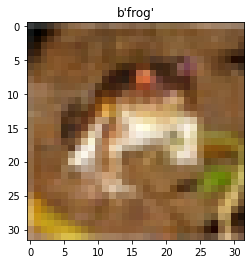

In [31]:
b1_fi = upImgs1[b'data'][0]
b1_fi = b1_fi.reshape(3, 32, 32)
b1_fi = b1_fi.transpose(1, 2, 0)
b1_fl = upImgs1[b'labels'][0]
plt.imshow(b1_fi)
plt.title(meta_data[b'label_names'][b1_fl])

In [32]:
upImgs1[b'data'][0].dtype

dtype('uint8')

In [48]:
labels = np.array(upImgs1[b'labels'])
label_names = np.array(meta_data[b'label_names'])
ImgLabelFeature = [(features[i], label_names[labels[i]]) for i in dataBatch1]

MemoryError: Unable to allocate 54.0 MiB for an array with shape (3072, 3, 3, 512) and data type float32

In [47]:
np.array(labels)[10000]

IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [ ]:
features = [] # for only databatch1, 10000 images from entire dataset
no = 0
ImgLabel = [] # consists images with corresponding feature and label
for i in dataBatch1:
    datasetFeatures = FeatureExtractorSISE().extractSISED(dataBatch1[i, ])
    no = no+1
    print(no)
    features.append(datasetFeatures)

In [ ]:
dists = np.linalg.norm(features-queryFeatures, axis=1) 
ids = np.argsort(dists)[:8]  # Top 8 results
scores = [dists[id] for id in ids]
print(scores)

In [53]:
array = [6, 1, 5, 2, 4, 3]
np.argsort(array)

array([1, 3, 5, 4, 2, 0], dtype=int64)

In [54]:
np.argsort(array)[:3]

array([1, 3, 5], dtype=int64)

In [32]:
arr1 = np.array([1,2,3,4,5])
dtype = [('index',int), ('feature',float)]
feat = [(1, features[0]), (2, 1.2), (3, 1.3), (4, 1.4)]
print(feat)

[(1, array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.00617675, 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)), (2, 1.2), (3, 1.3), (4, 1.4)]


In [14]:
featr = [(1,features[0]), (2,features[1]), (3,features[2])]
# featrs = []
# for i in features:
#     featrs.append(features[i])

In [15]:
featr.sort(key=lambda i:i[1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# featr = np.array([features[0], features[1], features[2], features[3], features[4]])

In [57]:
keys = [i for i in range(0,10000)]
values = features
myDict = dict(zip(keys,values))
print(myDict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [59]:
print(zip([1,2,3,4,5],[1,2,3,4,5]))

In [ ]:
a = np.array(feat, dtype=dtype)

In [ ]:
np.sort(a, order=['feature'])

In [14]:
features[3]

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.01963366],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [18]:
np.array([1.2,2.5,3,4,5]).dtype

dtype('float64')

In [19]:
features.dtype()

AttributeError: 'list' object has no attribute 'dtype'

==========================================

In [19]:
FeatureIndex = [(features[i],(i+1)) for i in range(0, 10000)] #list of (np arr, int)

In [20]:
FeatureIndex[9][0]

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.01345394, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.03202492, 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.00621598, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [21]:
DistIndex = [(np.linalg.norm(FeatureIndex[i][0]-queryFeatures, axis=1),(i+1)) for i in range(0, 10000)] #list of (float, int)

In [22]:
DistIndex

[(array([[0.        , 0.        , 0.        , ..., 0.        , 0.00617675,
          0.03793778],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.01062487]], dtype=float32),
  1),
 (array([[0.        , 0.        , 0.        , ..., 0.        , 0.00936317,
          0.03793778],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.01062487]], dtype=float32),
  2),
 (array([[0.        , 0.        , 0.        , ..., 0.        , 0.04174161,
          0.03793778],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.01062487]], dtype=float32),
  3),
 (array([[0.        , 0.        , 0.        , ...

In [13]:
Dist = [np.linalg.norm(features[i]-queryFeatures, axis=1) for i in range(0, 10000)] #list of float
Dist

[array([[0.        , 0.        , 0.        , ..., 0.        , 0.00617675,
         0.03793778],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.01062487]], dtype=float32),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.00936317,
         0.03793778],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.01062487]], dtype=float32),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.04174161,
         0.03793778],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.01062487]], dtype=float32),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.

In [36]:
np.array(Dist).shape

(10000, 3, 512)

In [15]:
Dist = np.array(Dist)
ids = np.argsort(Dist)[:8]
scr = [Dist[it] for it in ids]

In [43]:
scr1 = Dist[ids[0]]
scr1[:,:,0,0].shape

(3, 512)

In [16]:
print(scr)

[array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.00617675, 0.03793778],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.01062487]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.03793778],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.01062487]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.01235494, 0.03793778],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.00391759, 0.01062487]],

        ...,

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.00078525, 0.03793778],

In [18]:
scr[0]

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.00617675, 0.03793778],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.01062487]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.03793778],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.01062487]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.01235494, 0.03793778],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.00391759, 0.01062487]],

        ...,

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.00078525, 0.03793778],


In [20]:
f = features[np.where(features==scr[0])]
print(f.shape, Dist.shape)

C:\Users\Tejas\AppData\Local\Temp\ipykernel_24484\3119239039.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  f = features[np.where(features==scr[0])]


TypeError: list indices must be integers or slices, not tuple

In [21]:
print(np.where(features==Dist[0]))

(array([   0,    0,    0, ..., 9999, 9999, 9999], dtype=int64), array([0, 0, 0, ..., 2, 2, 2], dtype=int64), array([0, 0, 0, ..., 2, 2, 2], dtype=int64), array([  0,   1,   2, ..., 508, 509, 510], dtype=int64))


In [44]:
for i in range(0, 10000):
    cmp = (Dist[i] == scr1[:,:,0,0])
    if (cmp.all()):
        print(i)

In [37]:
Dist[0].shape

(3, 512)

In [38]:
scr[0][:,:,0,0].shape

(3, 512)

In [34]:
scr[0][:,:,0,0] == Dist[0]

array([[ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [27]:
scr[0].transpose(0, 2, 1, 3).shape

(3, 3, 512, 512)

In [19]:
a = np.array([[1,2.2,3,4], [5,6,7.3,8]])
b = np.array([[5,6.7,7,8], [10,11.6,12,13]])
for i in range(0, 2):
    c = (a[i] == b[0])
    if (c.all()):
        print(a.shape, b.shape, c.all())

In [21]:
c.dtype

dtype('bool')

In [30]:
a[0]

array([1. , 2.2, 3. , 4. ])

In [27]:
b1_fi = upImgs1[b'data'][f]
b1_fi = b1_fi.reshape(3, 32, 32)
b1_fi = b1_fi.transpose(1, 2, 0)
b1_fl = upImgs1[b'labels'][f]
plt.imshow(b1_fi)
plt.title(meta_data[b'label_names'][b1_fl])

IndexError: arrays used as indices must be of integer (or boolean) type